# Installation and import of required libraries

In [ ]:
!pip install transformers

In [17]:
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import random
import warnings
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
import nltk

nltk.download('wordnet')
warnings.filterwarnings('ignore')

# Manual seeding

In [7]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
seed = 123
transformers.set_seed(seed)
set_seeds(seed)

# Downloading model

In [11]:
model_checkpoint = "s-nlp/t5-paranmt-detox"
model= AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Model Evaluation

## Loading dataset

In [13]:
data_path='/content/preprocessed_ParaNMT-detox.csv'

In [14]:
df = pd.read_csv(data_path, index_col=0)
df

,reference,translation
0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t..."
1,you're becoming disgusting.,Now you're getting nasty.
4,I have orders to kill her.,I've got orders to put her down.
5,I'm not gonna have a child... ...with the same...,I'm not going to breed kids with a genetic dis...
10,you'd probably want me to buy you some chocola...,I suppose you want me to buy you flowers and c...
...,...,...
577759,"you're good, just a little immature.","They're okay, just a little immature."
577764,"execute him, Chief.","Carry on, Chief."
577770,I am so crazy nuts about you guys.,I'm so crazy about you guys.
577772,you didn't know that Estelle stole your fish f...,You didn't know that Estelle had stolen some f...


## Detoxificatoin of 10 samples

In [20]:
indeces = np.random.choice(df.index.tolist(), 10) # randomly choose 10 indeces
for index in indeces:

  device = 'cuda'
  tokenized = tokenizer(df['reference'][index], return_tensors="pt")["input_ids"] # tokenize source
  pred = model.generate(tokenized) # predict using tokenized source

  source = df['reference'][index] # initialize source
  prediction = tokenizer.decode(pred[0], skip_special_tokens=True) # decode prediction
  translation = df['translation'][index] # initialize translation

  # print metrics
  print('Source: ', source)
  print('Prediction: ', prediction)
  print('Translation: ', translation)
  print('Bleu score: ', sentence_bleu([tokenizer.tokenize(prediction)], tokenizer.tokenize(translation)))
  print('Meteor score: ', meteor_score([tokenizer.tokenize(prediction)], tokenizer.tokenize(translation)))
  print()

Source:  you're just scared of killing a man today.
Prediction:  You're just scared of killing a man today.
Translation:  I think you're just freaking out because you killed a guy today.
Bleu score:  3.5152852745683333e-78
Meteor score:  0.688395061728395

Source:  Damn near a hundred.
Prediction:  a hundred.
Translation:  hell, nearly all 100.
Bleu score:  1.1640469867513693e-231
Meteor score:  0.11904761904761905

Source:  you give me Ryan Wheeler, the old Wheeler, the jerk, you give me that.
Prediction:  You give me Ryan Wheeler, the old Wheeler, the snitch, you
Translation:  You give me Ryan Wheeler, the old Wheeler, the savage, you give me that guy,
Bleu score:  0.628450290578739
Meteor score:  0.807115606423565

Source:  This... this poor girl has every sexually transmitted disease you can get.
Prediction:  this poor girl has every sexually transmitted disease you can get.
Translation:  this poor thing... has all the communicable diseases you can get.
Bleu score:  0.2033344819004

## Calculation of bleu and meteor scores for 1000 samples

In [22]:
bleus = [] # list of bleu scores
meteors = [] # list of meteor scores
indeces = np.random.choice(df.index.tolist(), 1000) # randomly choose 1000 samples
for index in indeces:
  device = 'cuda'
  tokenized = tokenizer(df['reference'][index], return_tensors="pt")["input_ids"] # tokenize source
  pred = model.generate(tokenized) # predict using tokenized source

  source = df['reference'][index] # intialize source
  prediction = tokenizer.decode(pred[0], skip_special_tokens=True) # decode prediction
  translation = df['translation'][index] # initialize translation

  # calculate metrics
  bleu = sentence_bleu([tokenizer.tokenize(prediction)], tokenizer.tokenize(translation))
  meteor = meteor_score([tokenizer.tokenize(prediction)], tokenizer.tokenize(translation))

  # add metrics to the list
  bleus.append(bleu)
  meteors.append(meteor)

## Results visualization

In [23]:
import matplotlib.pyplot as plt
def visualize_metric(metric, name):
  counts, bins = np.histogram(metric)
  plt.title(f'{name} scores for 1000 samples histogram')
  plt.hist(bins[:-1], weights=counts)

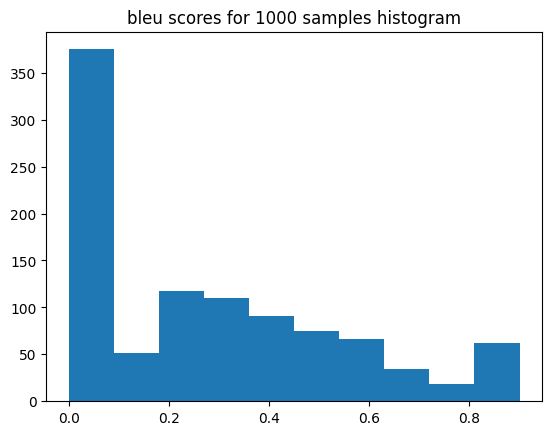

In [24]:
visualize_metric(bleus, 'bleu')

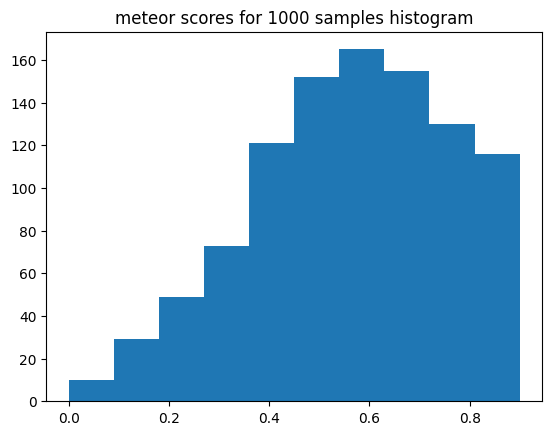

In [25]:
visualize_metric(meteors, 'meteor')